In [1]:
from keras.layers import Activation , Dense , Input ,Conv2DTranspose,Flatten
from keras.layers.convolutional import Conv2D,AtrousConvolution2D
from keras.layers import ReLU,BatchNormalization,Dropout,Reshape,Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Model, model_from_json
from keras.layers.convolutional import UpSampling2D
import keras.backend as k
import tensorflow as tf
import numpy as np
import PIL
import cv2
import IPython.display
import os




Using TensorFlow backend.


In [13]:

show_summary = True
Input_shape = (256,256,3)
Epochs =501
Batch =1
Mask_percentage = 0.25
Epsilon = 1e-9
alpha = 0.0004

In [3]:
def disc_loss(y_true,y_pred):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true,Epsilon)) + tf.math.log(tf.maximum(1-y_pred,Epsilon)))

d_input_shape = (Input_shape[0],int(Input_shape[1]*Mask_percentage*2),Input_shape[2])
d_dropout = 0.25
disc_optimizer = Adam(0.0001,0.5)

In [4]:
def d_build(layer_input,filter_size,kernel_size =4 ,strides= 2,activation='leakyrelu',dropout_rate = d_dropout,norm=True) :
    l = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        l = LeakyReLU(alpha =0.2)(l)
    if dropout_rate :
        l = Dropout(dropout_rate)(l)
    if norm == 'inst':
        l = BatchNormalization(momentum =0.8)(l)
    return l
    
def discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build(d_input, 32, 5,strides=2, norm=False)

    d = d_build(d, 64, 5, strides=2)
    d = d_build(d, 64, 5, strides=2)
    d = d_build(d, 128, 5, strides=2)
    d = d_build(d, 128, 5, strides=2)
    
    flat = Flatten()(d)
    f = Dense(1024, activation='relu')(flat)
    d_output = Dense(1,activation = 'sigmoid')(f)
    
    return Model(d_input,d_output)

In [5]:
D = discriminator()
D.compile(loss= disc_loss,optimizer=disc_optimizer)
if show_summary:
    D.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 32)       2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 64, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 64)        51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 32, 64)        0   

In [6]:
def gen_loss(y_true,y_pred):
    g_mse = k.mean(k.square(y_pred-y_true))
    return g_mse - alpha*tf.reduce_mean(tf.math.log(tf.maximum(y_pred,Epsilon)))
g_input_shape= (Input_shape[0],int(Input_shape[1]*Mask_percentage*2),Input_shape[2])
g_dropout= 0.25
g_optimizer = Adam(0.001,0.5)

In [7]:
def g_build_conv(layer_input,filter_size,kernel_size =4 ,strides= 2,activation='leakyrelu',dropout_rate = g_dropout,norm=True,dilation=1) :
    g = Conv2D(filter_size,kernel_size =kernel_size,strides = strides,padding='same',dilation_rate=(1, 1))(layer_input)
    if activation == 'leakyrelu':
        g = ReLU()(g)
    if dropout_rate :
        g = Dropout(dropout_rate)(g)
    if norm:
        g = BatchNormalization(momentum =0.8)(g)
        return g
    
def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d

def generator():
    g_input = Input(shape=g_input_shape)
    g1 = g_build_conv(g_input, 64, 5, strides=1)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 256, 4, strides=2)

    g4 = g_build_conv(g3, 512, 4, strides=1)
    g5 = g_build_conv(g4, 512, 4, strides=1)
    
    g6 = g_build_conv(g5, 512, 4, strides=1, dilation=2)
    g7 = g_build_conv(g6, 512, 4, strides=1, dilation=4)
    g8 = g_build_conv(g7, 512, 4, strides=1, dilation=8)
    g9 = g_build_conv(g8, 512, 4, strides=1, dilation=16)
    
    g10 = g_build_conv(g9, 512, 4, strides=1)
    g11 = g_build_conv(g10, 512, 4, strides=1)
    
    g12 = g_build_deconv(g11, 256, 4, strides=2)
    g13 = g_build_deconv(g12, 128, 4, strides=2)
    
    g14 = g_build_conv(g13, 128, 4, strides=1)
    g15 = g_build_conv(g14, 64, 4, strides=1)
    
    g_output = Conv2D(3, kernel_size=4, strides=(1,1), activation='tanh',padding='same', dilation_rate=(1,1))(g15)
    
    return Model(g_input,g_output)

In [8]:
G = generator()
G.compile(loss= gen_loss,optimizer=g_optimizer)
if show_summary:
    G.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 128, 64)      4864      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 128, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 128, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 64, 128)      131200    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 64, 128)      0   

In [9]:
Image = Input(shape=g_input_shape)
D.trainable = False
Gen_image= G(Image)
D_image = D(Gen_image)
Combined = Model(Image,[D_image,Gen_image])
Combined.compile(loss=['mse','mse'], optimizer = g_optimizer)

In [10]:
def masking(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width*Mask_percentage)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    Missing = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:,new_width:]
    return image,Missing

def mask_image(images):
    mask_images=[]
    missing_images=[]
    for image in images:
        mask_image,missing_image = masking(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images) , np.array(missing_images)

def demask_images(original,generated):
    demask_images=[]
    for o_image,g_image in zip(original,generated):
        width = g_image.shape[1] // 2
        first_part = g_image[:,:width]
        second_part = g_image[:,width:]
        o_image = np.concatenate((first_part,o_image,second_part),axis=1)
        demask_images.append(o_image)
        return np.array(demask_images)






In [11]:
def save_image(epoch,steps):
    train_image = cv2.imread('cdmc848.jpg',1)
    if train_image is None:
        train_image = cv2.imread('cdmc848.jpg',1)
        
    test_image = cv2.imread('cdmc848.jpg',1)
    if test_image is None:
        test_image = cv2.imread('cdmc848.jpg',1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
    mask_image_original , missing_image1 = masking(original)
    mask_image2 = mask_image_original.copy()
    mask_image2 = (mask_image2 / 127.5) - 1
    missing_image1 = (missing_image1 / 127.5 ) - 1
    #mask_image2= np.array(mask_image2)
    #missing_image1= np.array(missing_image1)
    mask_image2 = mask_image2.reshape(-1,256,128, 3)
    mask_image_original = mask_image_original.reshape(-1,256,128, 3)
    # missing_image1 = missing_image1.reshape(-1,256,128,3)        

    gen_missing = G.predict(mask_image2)
    gen_missing = (gen_missing + 1) * 127.5
    gen_missing = gen_missing.astype(np.uint8)
    demask_image = demask_images(mask_image_original, gen_missing)

    mask_image2 = (mask_image2 + 1) * 127.5
    mask_image2 = mask_image2.astype(np.uint8)
    border = np.zeros([original[0].shape[0], 10, 3]).astype(np.uint8)

    file_name = str(epoch) + "_" + str(steps) + ".jpg"
    final_image = np.concatenate((border,original,border,mask_image_original[0],border, demask_image[0], border), axis=1)
    SAVED_IMAGES ='C:/Users/sanchit jain/Desktop/ML/New folder (2)'
    cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
    final_image = final_image.astype('uint8')    
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    print("\t1.Original image \t 2.Input \t\t 3. Output")
    IPython.display.display(PIL.Image.fromarray(final_image))
    print("image saved")

epoch: 1,steps: 1, DIS loss: 10.36163330078125, GEN loss: 1.0371518,Identity loss: 0.03715178
epoch: 2,steps: 2, DIS loss: 10.36163330078125, GEN loss: 1.0383188,Identity loss: 0.03831879
epoch: 3,steps: 3, DIS loss: 10.36163330078125, GEN loss: 1.0394168,Identity loss: 0.03941673
epoch: 4,steps: 4, DIS loss: 10.36163330078125, GEN loss: 1.0376508,Identity loss: 0.037650816
epoch: 5,steps: 5, DIS loss: 10.36163330078125, GEN loss: 1.0358293,Identity loss: 0.035829335
epoch: 6,steps: 6, DIS loss: 10.36163330078125, GEN loss: 1.035762,Identity loss: 0.035762
epoch: 7,steps: 7, DIS loss: 10.36163330078125, GEN loss: 1.0377762,Identity loss: 0.037776183
epoch: 8,steps: 8, DIS loss: 10.36163330078125, GEN loss: 1.0375959,Identity loss: 0.037595823
epoch: 9,steps: 9, DIS loss: 10.36163330078125, GEN loss: 1.0371033,Identity loss: 0.037103318
epoch: 10,steps: 10, DIS loss: 10.36163330078125, GEN loss: 1.0379504,Identity loss: 0.037950374
epoch: 11,steps: 11, DIS loss: 10.36163330078125, GEN l

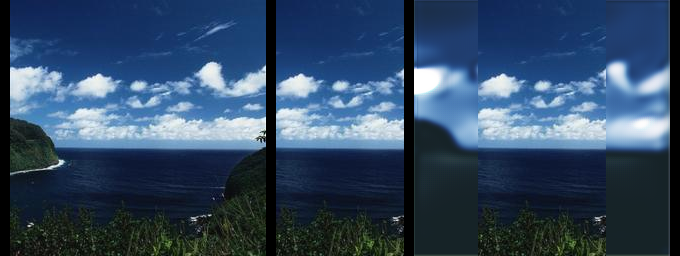

image saved
epoch: 51,steps: 51, DIS loss: 10.36163330078125, GEN loss: 1.0282096,Identity loss: 0.028209615
epoch: 52,steps: 52, DIS loss: 10.36163330078125, GEN loss: 1.0338993,Identity loss: 0.033899352
epoch: 53,steps: 53, DIS loss: 10.36163330078125, GEN loss: 1.0278798,Identity loss: 0.027879814
epoch: 54,steps: 54, DIS loss: 10.36163330078125, GEN loss: 1.0324214,Identity loss: 0.032421373
epoch: 55,steps: 55, DIS loss: 10.36163330078125, GEN loss: 1.0295969,Identity loss: 0.029596908
epoch: 56,steps: 56, DIS loss: 10.36163330078125, GEN loss: 1.0296307,Identity loss: 0.029630639
epoch: 57,steps: 57, DIS loss: 10.36163330078125, GEN loss: 1.030082,Identity loss: 0.030082045
epoch: 58,steps: 58, DIS loss: 10.36163330078125, GEN loss: 1.0282173,Identity loss: 0.028217327
epoch: 59,steps: 59, DIS loss: 10.36163330078125, GEN loss: 1.0272738,Identity loss: 0.027273757
epoch: 60,steps: 60, DIS loss: 10.36163330078125, GEN loss: 1.0299236,Identity loss: 0.02992358
epoch: 61,steps: 61,

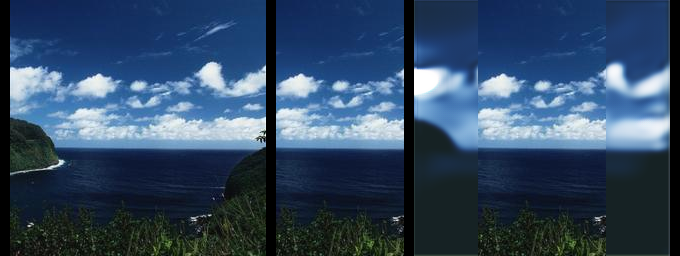

image saved
epoch: 101,steps: 101, DIS loss: 10.36163330078125, GEN loss: 1.0265408,Identity loss: 0.026540715
epoch: 102,steps: 102, DIS loss: 10.36163330078125, GEN loss: 1.0288891,Identity loss: 0.028889025
epoch: 103,steps: 103, DIS loss: 10.36163330078125, GEN loss: 1.0260124,Identity loss: 0.026012454
epoch: 104,steps: 104, DIS loss: 10.36163330078125, GEN loss: 1.0261862,Identity loss: 0.026186174
epoch: 105,steps: 105, DIS loss: 10.36163330078125, GEN loss: 1.0255349,Identity loss: 0.025534913
epoch: 106,steps: 106, DIS loss: 10.36163330078125, GEN loss: 1.0302153,Identity loss: 0.030215312
epoch: 107,steps: 107, DIS loss: 10.36163330078125, GEN loss: 1.0328757,Identity loss: 0.032875627
epoch: 108,steps: 108, DIS loss: 10.36163330078125, GEN loss: 1.0274227,Identity loss: 0.027422652
epoch: 109,steps: 109, DIS loss: 10.36163330078125, GEN loss: 1.0258379,Identity loss: 0.025837842
epoch: 110,steps: 110, DIS loss: 10.36163330078125, GEN loss: 1.0259755,Identity loss: 0.02597547

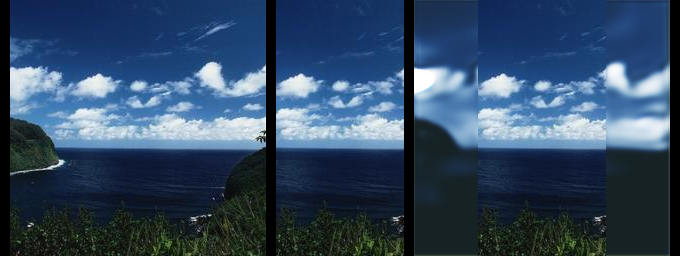

image saved
epoch: 151,steps: 151, DIS loss: 10.36163330078125, GEN loss: 1.0241829,Identity loss: 0.024182934
epoch: 152,steps: 152, DIS loss: 10.36163330078125, GEN loss: 1.0251282,Identity loss: 0.025128268
epoch: 153,steps: 153, DIS loss: 10.36163330078125, GEN loss: 1.0233165,Identity loss: 0.023316525
epoch: 154,steps: 154, DIS loss: 10.36163330078125, GEN loss: 1.023653,Identity loss: 0.023653058
epoch: 155,steps: 155, DIS loss: 10.36163330078125, GEN loss: 1.0254326,Identity loss: 0.025432538
epoch: 156,steps: 156, DIS loss: 10.36163330078125, GEN loss: 1.0237277,Identity loss: 0.023727601
epoch: 157,steps: 157, DIS loss: 10.36163330078125, GEN loss: 1.0270472,Identity loss: 0.027047198
epoch: 158,steps: 158, DIS loss: 10.36163330078125, GEN loss: 1.0233274,Identity loss: 0.023327388
epoch: 159,steps: 159, DIS loss: 10.36163330078125, GEN loss: 1.0244766,Identity loss: 0.024476618
epoch: 160,steps: 160, DIS loss: 10.36163330078125, GEN loss: 1.0240134,Identity loss: 0.02401341


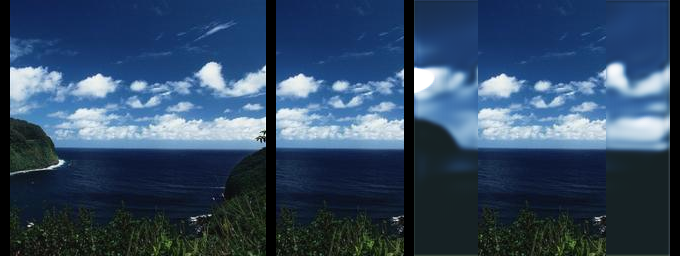

image saved
epoch: 201,steps: 201, DIS loss: 10.36163330078125, GEN loss: 1.0256737,Identity loss: 0.02567374
epoch: 202,steps: 202, DIS loss: 10.36163330078125, GEN loss: 1.0233532,Identity loss: 0.023353264
epoch: 203,steps: 203, DIS loss: 10.36163330078125, GEN loss: 1.0230345,Identity loss: 0.023034465
epoch: 204,steps: 204, DIS loss: 10.36163330078125, GEN loss: 1.0222583,Identity loss: 0.022258293
epoch: 205,steps: 205, DIS loss: 10.36163330078125, GEN loss: 1.0229198,Identity loss: 0.022919815
epoch: 206,steps: 206, DIS loss: 10.36163330078125, GEN loss: 1.0223352,Identity loss: 0.022335205
epoch: 207,steps: 207, DIS loss: 10.36163330078125, GEN loss: 1.0224435,Identity loss: 0.022443477
epoch: 208,steps: 208, DIS loss: 10.36163330078125, GEN loss: 1.0222154,Identity loss: 0.02221537
epoch: 209,steps: 209, DIS loss: 10.36163330078125, GEN loss: 1.0222424,Identity loss: 0.022242395
epoch: 210,steps: 210, DIS loss: 10.36163330078125, GEN loss: 1.0221677,Identity loss: 0.022167671


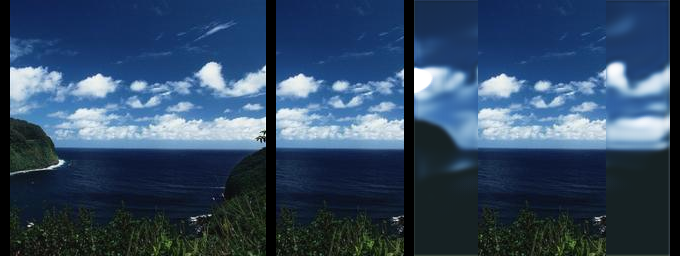

image saved
epoch: 251,steps: 251, DIS loss: 10.36163330078125, GEN loss: 1.0210743,Identity loss: 0.021074269
epoch: 252,steps: 252, DIS loss: 10.36163330078125, GEN loss: 1.0208979,Identity loss: 0.020897884
epoch: 253,steps: 253, DIS loss: 10.36163330078125, GEN loss: 1.0237507,Identity loss: 0.023750685
epoch: 254,steps: 254, DIS loss: 10.36163330078125, GEN loss: 1.0208206,Identity loss: 0.020820662
epoch: 255,steps: 255, DIS loss: 10.36163330078125, GEN loss: 1.0253872,Identity loss: 0.025387168
epoch: 256,steps: 256, DIS loss: 10.36163330078125, GEN loss: 1.0205295,Identity loss: 0.020529503
epoch: 257,steps: 257, DIS loss: 10.36163330078125, GEN loss: 1.0206796,Identity loss: 0.020679643
epoch: 258,steps: 258, DIS loss: 10.36163330078125, GEN loss: 1.0213455,Identity loss: 0.021345459
epoch: 259,steps: 259, DIS loss: 10.36163330078125, GEN loss: 1.0201823,Identity loss: 0.020182297
epoch: 260,steps: 260, DIS loss: 10.36163330078125, GEN loss: 1.0203223,Identity loss: 0.02032227

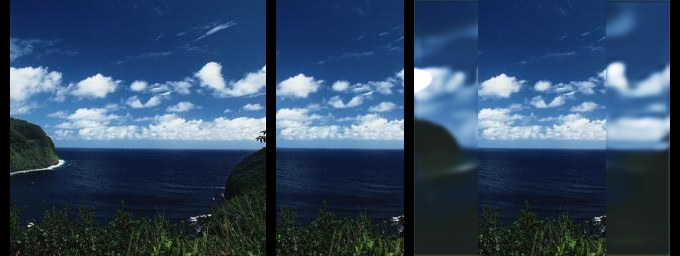

image saved
epoch: 301,steps: 301, DIS loss: 10.36163330078125, GEN loss: 1.0195248,Identity loss: 0.019524869
epoch: 302,steps: 302, DIS loss: 10.36163330078125, GEN loss: 1.0186929,Identity loss: 0.018692907
epoch: 303,steps: 303, DIS loss: 10.36163330078125, GEN loss: 1.0186375,Identity loss: 0.018637529
epoch: 304,steps: 304, DIS loss: 10.36163330078125, GEN loss: 1.0197425,Identity loss: 0.01974247
epoch: 305,steps: 305, DIS loss: 10.36163330078125, GEN loss: 1.0180081,Identity loss: 0.0180081
epoch: 306,steps: 306, DIS loss: 10.36163330078125, GEN loss: 1.0173959,Identity loss: 0.017395837
epoch: 307,steps: 307, DIS loss: 10.36163330078125, GEN loss: 1.0189551,Identity loss: 0.0189551
epoch: 308,steps: 308, DIS loss: 10.36163330078125, GEN loss: 1.0181254,Identity loss: 0.018125359
epoch: 309,steps: 309, DIS loss: 10.36163330078125, GEN loss: 1.0198913,Identity loss: 0.019891288
epoch: 310,steps: 310, DIS loss: 10.36163330078125, GEN loss: 1.0208781,Identity loss: 0.020878036
epo

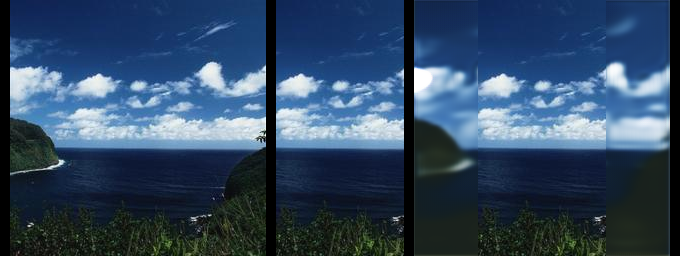

image saved
epoch: 351,steps: 351, DIS loss: 10.36163330078125, GEN loss: 1.0167369,Identity loss: 0.016736869
epoch: 352,steps: 352, DIS loss: 10.36163330078125, GEN loss: 1.0186309,Identity loss: 0.018630907
epoch: 353,steps: 353, DIS loss: 10.36163330078125, GEN loss: 1.0171154,Identity loss: 0.017115362
epoch: 354,steps: 354, DIS loss: 10.36163330078125, GEN loss: 1.016289,Identity loss: 0.016288972
epoch: 355,steps: 355, DIS loss: 10.36163330078125, GEN loss: 1.0162836,Identity loss: 0.016283643
epoch: 356,steps: 356, DIS loss: 10.36163330078125, GEN loss: 1.0181785,Identity loss: 0.018178511
epoch: 357,steps: 357, DIS loss: 10.36163330078125, GEN loss: 1.0185518,Identity loss: 0.018551819
epoch: 358,steps: 358, DIS loss: 10.36163330078125, GEN loss: 1.0176781,Identity loss: 0.017678112
epoch: 359,steps: 359, DIS loss: 10.36163330078125, GEN loss: 1.0170408,Identity loss: 0.017040862
epoch: 360,steps: 360, DIS loss: 10.36163330078125, GEN loss: 1.016808,Identity loss: 0.01680807
e

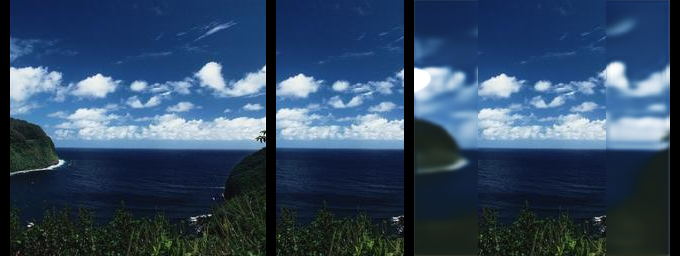

image saved
epoch: 401,steps: 401, DIS loss: 10.36163330078125, GEN loss: 1.016111,Identity loss: 0.016111067
epoch: 402,steps: 402, DIS loss: 10.36163330078125, GEN loss: 1.0166118,Identity loss: 0.016611788
epoch: 403,steps: 403, DIS loss: 10.36163330078125, GEN loss: 1.0198953,Identity loss: 0.019895373
epoch: 404,steps: 404, DIS loss: 10.36163330078125, GEN loss: 1.0151757,Identity loss: 0.015175643
epoch: 405,steps: 405, DIS loss: 10.36163330078125, GEN loss: 1.0163822,Identity loss: 0.016382238
epoch: 406,steps: 406, DIS loss: 10.36163330078125, GEN loss: 1.016299,Identity loss: 0.01629905
epoch: 407,steps: 407, DIS loss: 10.36163330078125, GEN loss: 1.0169827,Identity loss: 0.016982695
epoch: 408,steps: 408, DIS loss: 10.36163330078125, GEN loss: 1.0173073,Identity loss: 0.01730733
epoch: 409,steps: 409, DIS loss: 10.36163330078125, GEN loss: 1.016211,Identity loss: 0.016211059
epoch: 410,steps: 410, DIS loss: 10.36163330078125, GEN loss: 1.0160233,Identity loss: 0.0160233
epoch

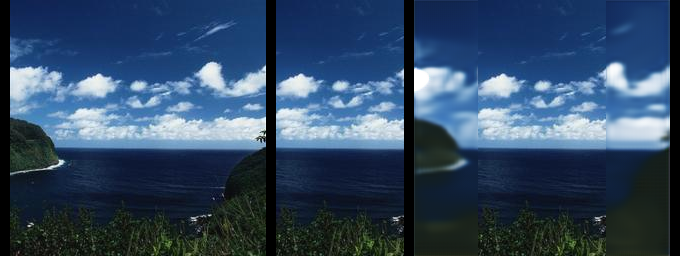

image saved
epoch: 451,steps: 451, DIS loss: 10.36163330078125, GEN loss: 1.0143247,Identity loss: 0.014324696
epoch: 452,steps: 452, DIS loss: 10.36163330078125, GEN loss: 1.0144907,Identity loss: 0.014490761
epoch: 453,steps: 453, DIS loss: 10.36163330078125, GEN loss: 1.0152808,Identity loss: 0.015280841
epoch: 454,steps: 454, DIS loss: 10.36163330078125, GEN loss: 1.0136994,Identity loss: 0.013699381
epoch: 455,steps: 455, DIS loss: 10.36163330078125, GEN loss: 1.0138395,Identity loss: 0.013839539
epoch: 456,steps: 456, DIS loss: 10.36163330078125, GEN loss: 1.0154079,Identity loss: 0.015407917
epoch: 457,steps: 457, DIS loss: 10.36163330078125, GEN loss: 1.0162594,Identity loss: 0.016259378
epoch: 458,steps: 458, DIS loss: 10.36163330078125, GEN loss: 1.0151786,Identity loss: 0.015178573
epoch: 459,steps: 459, DIS loss: 10.36163330078125, GEN loss: 1.0155021,Identity loss: 0.015502056
epoch: 460,steps: 460, DIS loss: 10.36163330078125, GEN loss: 1.0148964,Identity loss: 0.01489645

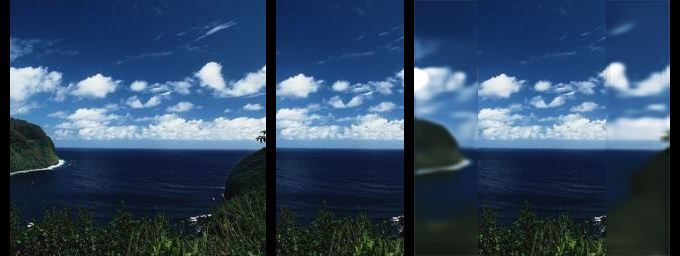

image saved


In [14]:
x= cv2.imread('cdmc848.jpg',1)
steps = 1  
    
for epoch in range(1,Epochs):
        test = None
       # Batch_size = x.shape[0]
        y_real = np.ones([1,1])
        y_fake = np.zeros([1,1])
        #  x = x.reshape(256,256,3)    
        mask_image1,missing_image = masking(x)
        mask_image1 = (mask_image1/127.5) - 1
        missing_image = (missing_image/127.5) - 1
        #mask_image1= np.array(mask_image1)
        # missing_image= np.array(missing_image)
        
        # x = np.array(x)
        # x = x.reshape(-1,256,256,3)
        mask_image1 = mask_image1.reshape(-1,256,128, 3)
        missing_image = missing_image.reshape(-1,256,128,3)
        gen_predict = G.predict(mask_image1)
        
        d_loss_real = D.train_on_batch(missing_image,y_real)
        d_loss_fake = D.train_on_batch(gen_predict,y_fake)
        d_loss = 0.5*np.add(d_loss_real,d_loss_fake)

        for i in range(2):
            g_loss = Combined.train_on_batch(mask_image1,[y_real,missing_image])
        
        
        log = "epoch: %d,steps: %d, DIS loss: %s, GEN loss: %s,Identity loss: %s" \
                                            %(epoch,steps, str(d_loss),str(g_loss[0]), str(g_loss[2]))
        
        print(log)    
        steps += 1    
        if(epoch % 50 ==0 ):
            save_image(epoch,steps)
    